In [1]:
# packages
import jax.ops as jop
import jax.numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt

from jax import grad, vmap

from numpy import random 

Code for solution of the Burgers equation 
\begin{equation*}
\begin{aligned}
& u_t+\alpha u u_x-(0.01/\pi)u_{xx}=f, x \in [-1,1], t \in [0,1]\\
& u(0,x)=-\sin(\pi x)\\
& u(t,-1)=u(t,1)=0
\end{aligned}
\end{equation*}

where $f=0$

In [2]:
# fix random seeds, for generating reference solution & sampled points
random.seed(20)

# we use x=(x1,x2) as (t,x)
alpha = 1 # control the nonlinearity

# boundary condition
def u(x1, x2):
    return -jnp.sin(jnp.pi*x2)*(x1==0) + 0*(x2==0)

# right hand side
def f(x1, x2):
    return 0
#     return grad(u,0)(x1,x2)+alpha*u(x1,x2)*grad(u,1)(x1,x2)-(0.01/jnp.pi)*grad(grad(u,1),1)(x1,x2)

In [3]:
[Gauss_pts, weights] = onp.polynomial.hermite.hermgauss(80)
# ground truth
nu = 0.1/onp.pi

def u_true(x1, x2):
    temp = x2-onp.sqrt(4*nu*x1)*Gauss_pts
    val1 = weights * onp.sin(onp.pi*temp) * onp.exp(-onp.cos(onp.pi*temp)/(2*onp.pi*nu))
    val2 = weights * onp.exp(-onp.cos(onp.pi*temp)/(2*onp.pi*nu))
    return -onp.sum(val1)/onp.sum(val2)



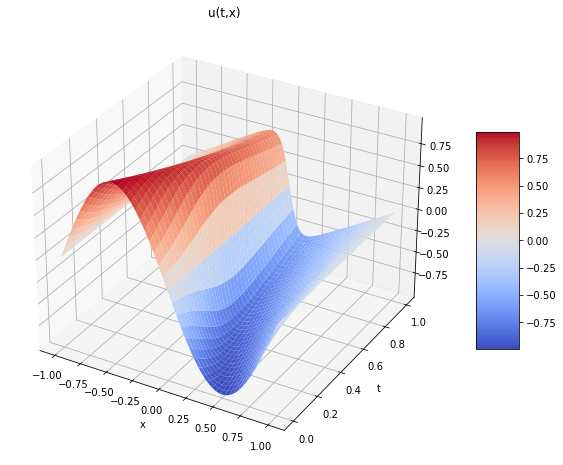

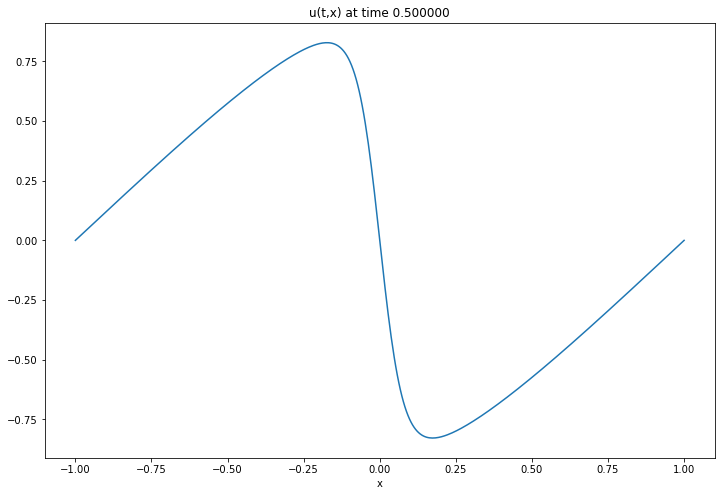

In [4]:
# plot the solution u(x,y)
    
def plot_u(num_pts1, num_pts2):
    xx = onp.linspace(0, 1, num_pts1)
    yy = onp.linspace(-1, 1, num_pts2)
    XX, YY = onp.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = onp.array(XX.flatten())
    YYv = onp.array(YY.flatten())

    ZZ_u = onp.vectorize(u_true)(XXv, YYv)
    ZZ_u = ZZ_u.reshape(num_pts2,num_pts1)
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    u_surf=ax.plot_surface(YY, XX, ZZ_u, cmap=plt.cm.coolwarm)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('u(t,x)')
    
    fig.colorbar(u_surf, shrink= 0.5, aspect = 5)
    plt.show()
    
def plot_u_time_t(t, num_pts):
    xx = t
    yy = onp.linspace(-1, 1, num_pts)
    XX, YY = onp.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = onp.array(XX.flatten())
    YYv = onp.array(YY.flatten())

    ZZ_u = onp.vectorize(u_true)(XXv, YYv)
    
    fig = plt.figure(figsize=(12,8))
    plt.plot(yy, ZZ_u)
    plt.xlabel('x')
    plt.title('u(t,x) at time %f' %t)
    plt.show()
    
# plot the figure
plot_u(40,400)
# plot_f(40)
plot_u_time_t(0.5,400)

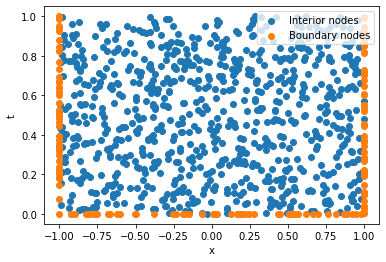

In [5]:
# sampled points

def sample_points(N_domain, N_boundary):
    # interior nodes
    X_domain = random.uniform(0, 1.0, (N_domain, 2))
    X_domain[:,1] = 2*X_domain[:,1]-1
    X_boundary = onp.zeros((N_boundary, 2))

    # generate random boundary points on the faces of the domain 

    # bottom face
    X_boundary[:int(N_boundary/3), 1] = random.uniform(-1.0, 1.0, int(N_boundary/3))
    # right face
    X_boundary[int(N_boundary/3):2*int(N_boundary/3), 0] = random.uniform(0.0, 1.0, int(N_boundary/3))
    X_boundary[int(N_boundary/3):2*int(N_boundary/3), 1] = 1
    # left face
    X_boundary[2*int(N_boundary/3):, 0] = random.uniform(0.0, 1.0, int(N_boundary/3))
    X_boundary[2*int(N_boundary/3):, 1] = -1

    fig, ax = plt.subplots()
    ax.scatter(X_domain[range(N_domain), 1], X_domain[range(N_domain), 0], label='Interior nodes')
    ax.scatter(X_boundary[range(N_boundary), 1], X_boundary[range(N_boundary), 0], label='Boundary nodes')
    ax.legend(loc="upper right")
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    plt.show()
    return X_domain, X_boundary

N_domain_tot = 800
N_boundary_tot = 150
X_domain_tot, X_boundary_tot = sample_points(N_domain_tot, N_boundary_tot)

Define kernels

kernel for both time and space is
$$k(x,y) = \sum_{i=0}^{s_1} \frac{1}{\alpha^i} \exp(-\gamma^i|x-y|^2) + \sum_{i=0}^{s_2} \frac{1}{\beta^i} \tanh(\xi^i(xy-c))+d $$
The final kernel is "space kernel * time kernel"

$s_1$: number of scales in squared exp

$s_2$: number of scales in tanh

Using KF to train $\alpha, \beta, \gamma, \xi$ with fixed $c=-\frac{1}{4}, d=1$

In [6]:
# Define a real valued kernel kappa(x, y; sigma) \to R
def kappa(x1, x2, y1, y2, sigma):
    # x,y are 2D input row vectors
    
    # squared exponential kernel
    alpha = sigma[0]
    gamma = sigma[1]
    
    # hyperbolic tangent kernel
    beta = sigma[2]
    xi = sigma[3]
    c = -1/4
    d = 1
    
    # kernel for time variable
    num_scale1 = 7
    arr_scale1 = jnp.arange(0,num_scale1)
    val_t = jnp.sum(1/(alpha**arr_scale1) * jnp.exp(-(gamma**arr_scale1)*((x1-y1)**2)))
    val_t = val_t + jnp.sum(1/(beta**arr_scale1) * jnp.tanh((xi**arr_scale1)*(x1*y1-c))) + d
    
    # kernel for space variable
    num_scale2 = 7
    arr_scale2 = jnp.arange(0,num_scale2)
    val_x = jnp.sum(1/(alpha**arr_scale2) * jnp.exp(-(gamma**arr_scale2)*((x2-y2)**2)))
    val_x = val_x + jnp.sum(1/(beta**arr_scale2) * jnp.tanh((xi**arr_scale2)*(x2*y2-c))) + d
    
    return val_t*val_x


def D_x1_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,0)(x1, x2, y1, y2, sigma)
    return val

def D_x2_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,1)(x1, x2, y1, y2, sigma)
    return val

def DD_x2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa,1),1)(x1, x2, y1, y2, sigma)
    return val

def D_y1_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,2)(x1, x2, y1, y2, sigma)
    return val

def D_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,3)(x1, x2, y1, y2, sigma)
    return val

def DD_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa,3),3)(x1, x2, y1, y2, sigma)
    return val

def D_x1_D_y1_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa,0),2)(x1, x2, y1, y2, sigma)
    return val

def D_x1_D_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa,0),3)(x1, x2, y1, y2, sigma)
    return val

def D_x1_DD_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(grad(kappa,0),3),3)(x1, x2, y1, y2, sigma)
    return val

def D_x2_D_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa,1),3)(x1, x2, y1, y2, sigma)
    return val

def D_x2_DD_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(grad(kappa,1),3),3)(x1, x2, y1, y2, sigma)
    return val

def DD_x2_DD_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(grad(grad(kappa,1),1),3),3)(x1, x2, y1, y2, sigma)
    return val


We organize all the variables in the way: $[v_1,v_2,v_3,v_0,v_b]$, where $v_0, v_1, v_2, v_3$ represent the interior nodal values of $u(x_i), u_t(x_i), u_x(x_i), u_{xx}(x_i)$, respectively; and $v_b$ is the boundary value. 

The Gram matrix $\Theta$ is then determined by this organization. Next code block is to construct this matrix.


In [7]:
# vectorized construction of the Gram matrix Theta
def assembly_Theta(X_domain, X_boundary, nugget, set_sigma):
    N_domain = X_domain.shape[0]
    N_boundary = X_boundary.shape[0]
    Theta = jnp.zeros((4*N_domain + N_boundary, 4*N_domain + N_boundary))

    # auxiliary variables to make things readable
    # interior points coordinates
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]
    
    # interior + boundary points coordinates
    Xdb0=jnp.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    Xdb1=jnp.concatenate([Xd1, X_boundary[:N_boundary, 1]])

    # interior v.s. interior interaction (used for construct kernel matrix)
    XXdd0=jnp.transpose(jnp.tile(Xd0,(N_domain,1)))
    XXdd1=jnp.transpose(jnp.tile(Xd1,(N_domain,1)))

    # interior+boudary v.s. interior+bpundary interaction
    XXdbdb0=jnp.transpose(jnp.tile(Xdb0,(N_domain+N_boundary,1)))
    XXdbdb1=jnp.transpose(jnp.tile(Xdb1,(N_domain+N_boundary,1)))

    # interior v.s. interior+boundary interaction
    XXddb0=jnp.transpose(jnp.tile(Xd0,(N_domain+N_boundary,1)))
    XXddb1=jnp.transpose(jnp.tile(Xd1,(N_domain+N_boundary,1)))
    XXddb0_2=jnp.tile(Xdb0,(N_domain,1))
    XXddb1_2=jnp.tile(Xdb1,(N_domain,1))

    # Construct kernel matrix
    # interior v.s. interior 
    val = vmap(lambda x1, x2, y1, y2: D_x1_D_y1_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
    Theta = jop.index_update(Theta, jop.index[0:N_domain, 0:N_domain], jnp.reshape(val, (N_domain, N_domain)))
    
    val = vmap(lambda x1, x2, y1, y2: D_x1_D_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
#     Theta[0:N_domain, N_domain:2*N_domain] =  jnp.reshape(val, (N_domain, N_domain))
    Theta = jop.index_update(Theta, jop.index[0:N_domain, N_domain:2*N_domain], jnp.reshape(val, (N_domain, N_domain)))
#     Theta[N_domain:2*N_domain, 0:N_domain] = jnp.transpose(onp.reshape(val, (N_domain, N_domain)))
    Theta = jop.index_update(Theta, jop.index[N_domain:2*N_domain, 0:N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain))))
    
    val = vmap(lambda x1, x2, y1, y2: D_x1_DD_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
#     Theta[0:N_domain, 2*N_domain:3*N_domain] =  jnp.reshape(val, (N_domain, N_domain))
    Theta = jop.index_update(Theta, jop.index[0:N_domain, 2*N_domain:3*N_domain], jnp.reshape(val, (N_domain, N_domain)))
#     Theta[2*N_domain:3*N_domain, 0:N_domain] =  jnp.transpose(onp.reshape(val, (N_domain, N_domain)))
    Theta = jop.index_update(Theta, jop.index[2*N_domain:3*N_domain, 0:N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain))))
    
    val = vmap(lambda x1, x2, y1, y2: D_x2_D_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
#     Theta[N_domain:2*N_domain, N_domain:2*N_domain] =  jnp.reshape(val, (N_domain, N_domain))
    Theta = jop.index_update(Theta, jop.index[N_domain:2*N_domain, N_domain:2*N_domain], jnp.reshape(val, (N_domain, N_domain)))
    
    val = vmap(lambda x1, x2, y1, y2: D_x2_DD_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
#     Theta[N_domain:2*N_domain, 2*N_domain:3*N_domain] =  jnp.reshape(val, (N_domain, N_domain))
    Theta = jop.index_update(Theta, jop.index[N_domain:2*N_domain, 2*N_domain:3*N_domain], jnp.reshape(val, (N_domain, N_domain)))
#     Theta[2*N_domain:3*N_domain, N_domain:2*N_domain] =  jnp.transpose(onp.reshape(val, (N_domain, N_domain)))
    Theta = jop.index_update(Theta, jop.index[2*N_domain:3*N_domain, N_domain:2*N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain))))
    
    val = vmap(lambda x1, x2, y1, y2: DD_x2_DD_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
#     Theta[2*N_domain:3*N_domain, 2*N_domain:3*N_domain] =  jnp.reshape(val, (N_domain, N_domain))
    Theta = jop.index_update(Theta, jop.index[2*N_domain:3*N_domain, 2*N_domain:3*N_domain], jnp.reshape(val, (N_domain, N_domain)))
    
    # interior+boundary v.s. interior+boundary
    val = vmap(lambda x1, x2, y1, y2: kappa(x1, x2, y1, y2, set_sigma))(XXdbdb0.flatten(),XXdbdb1.flatten(),jnp.transpose(XXdbdb0).flatten(),jnp.transpose(XXdbdb1).flatten())
#     Theta[3*N_domain:, 3*N_domain:] =  jnp.reshape(val, (N_domain+N_boundary, N_domain+N_boundary))
    Theta = jop.index_update(Theta, jop.index[3*N_domain:, 3*N_domain:], jnp.reshape(val, (N_domain+N_boundary, N_domain+N_boundary)))
    
    # interior v.s. interior+boundary
    val = vmap(lambda x1, x2, y1, y2: D_x1_kappa(x1, x2, y1, y2, set_sigma))(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten())
#     Theta[0:N_domain, 3*N_domain:] = jnp.reshape(val, (N_domain, N_domain+N_boundary))
    Theta = jop.index_update(Theta, jop.index[0:N_domain, 3*N_domain:], jnp.reshape(val, (N_domain, N_domain+N_boundary)))
#     Theta[3*N_domain:, 0:N_domain] = jnp.transpose(onp.reshape(val, (N_domain, N_domain+N_boundary)))
    Theta = jop.index_update(Theta, jop.index[3*N_domain:, 0:N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain+N_boundary))))
    
    val = vmap(lambda x1, x2, y1, y2: D_x2_kappa(x1, x2, y1, y2, set_sigma))(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten())
#     Theta[N_domain:2*N_domain, 3*N_domain:] = jnp.reshape(val, (N_domain, N_domain+N_boundary))
    Theta = jop.index_update(Theta, jop.index[N_domain:2*N_domain, 3*N_domain:], jnp.reshape(val, (N_domain, N_domain+N_boundary)))
#     Theta[3*N_domain:, N_domain:2*N_domain] = jnp.transpose(onp.reshape(val, (N_domain, N_domain+N_boundary)))
    Theta = jop.index_update(Theta, jop.index[3*N_domain:, N_domain:2*N_domain], jnp.transpose(onp.reshape(val, (N_domain, N_domain+N_boundary))))
    
    val = vmap(lambda x1, x2, y1, y2: DD_x2_kappa(x1, x2, y1, y2, set_sigma))(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten())
#     Theta[2*N_domain:3*N_domain, 3*N_domain:] = jnp.reshape(val, (N_domain, N_domain+N_boundary))
    Theta = jop.index_update(Theta, jop.index[2*N_domain:3*N_domain, 3*N_domain:], jnp.reshape(val, (N_domain, N_domain+N_boundary)))
#     Theta[3*N_domain:, 2*N_domain:3*N_domain] = jnp.transpose(onp.reshape(val, (N_domain, N_domain+N_boundary)))
    Theta = jop.index_update(Theta, jop.index[3*N_domain:, 2*N_domain:3*N_domain], jnp.transpose(jnp.reshape(val, (N_domain, N_domain+N_boundary))))
    
    # calculate trace
    trace1 = jnp.trace(Theta[:N_domain, :N_domain])
    trace2 = jnp.trace(Theta[N_domain:2*N_domain, N_domain:2*N_domain])
    trace3 = jnp.trace(Theta[2*N_domain:3*N_domain, 2*N_domain:3*N_domain])
    trace4 = jnp.trace(Theta[3*N_domain:, 3*N_domain:])
    ratio = [trace1/trace4, trace2/trace4, trace3/trace4]
    
    temp=jnp.concatenate((ratio[0]*jnp.ones((1,N_domain)), ratio[1]*jnp.ones((1,N_domain)), ratio[2]*jnp.ones((1,N_domain)), jnp.ones((1,N_domain+N_boundary))), axis=1)
    Theta = Theta + nugget*jnp.diag(temp[0]) 
    L = jnp.linalg.cholesky(Theta)
    
    return L


We add nugget terms to regularize the Gram matrix
\begin{equation*}
\Theta_{\lambda} = \Theta +
\text{nugget}\times\begin{bmatrix}
\lambda_1 I & 0 & 0 & 0\\
0 & \lambda_2 I & 0 & 0\\
0 & 0 & \lambda_3I & 0 \\
0 & 0 & 0 & I
\end{bmatrix}
\end{equation*}
where $\lambda_1, \lambda_2, \lambda_3$ are selected to be the trace ratios of the orginal Gram matrix

Then, we solve the following optimization problem:
\begin{equation*}
\begin{aligned}
\min&\quad   [v_1,v_2,v_3,v_0,v_b]\Theta_{\lambda}^{-1} [v_1,v_2,v_3,v_0,v_b]^T\\
  \text{s.t.}&\quad v_1+\alpha v_0v_2-(0.01/\pi)v_3=f, \text{ and } v_b = \text{boundary data}
\end{aligned}
\end{equation*}

Here, $v_0, v_1, v_2, v_3$ represent the interior nodal values of $u(x_i), u_t(x_i), u_x(x_i), u_{xx}(x_i)$, respectively.

In [8]:
def J(v,rhs_f,bdy_g,L):
    N_domain = rhs_f.shape[0]
    v0 = v[:N_domain]
    v2 = v[N_domain:2*N_domain]
    v3 = v[2*N_domain:]
    
    vv = jnp.append(nu*v3+rhs_f-alpha*v0*v2, v2)
    vv = jnp.append(vv, v3)
    vv = jnp.append(vv, v0)
    vv = jnp.append(vv, bdy_g)
    temp = jnp.linalg.solve(L,vv)
    return jnp.dot(temp, temp)

grad_J = grad(J)

def Hessian_GN(v,rhs_f,bdy_g,L):
    N_domain = rhs_f.shape[0]
    N_boundary = bdy_g.shape[0]
    v0 = v[:N_domain]
    v2 = v[N_domain:2*N_domain]
    v3 = v[2*N_domain:]

    mtx = jnp.zeros((4*N_domain+N_boundary, 3*N_domain))
    mtx1 = jnp.concatenate((-alpha*jnp.diag(v2), -alpha*jnp.diag(v0), nu*jnp.eye(N_domain)), axis=1)
    mtx = jop.index_update(mtx, jop.index[0:N_domain, :], mtx1)
    mtx = jop.index_update(mtx, jop.index[N_domain:2*N_domain, N_domain:2*N_domain], jnp.eye(N_domain))
    mtx = jop.index_update(mtx, jop.index[2*N_domain:3*N_domain, 2*N_domain:3*N_domain], jnp.eye(N_domain))
    mtx = jop.index_update(mtx, jop.index[3*N_domain:4*N_domain, :N_domain], jnp.eye(N_domain))
    ss = jnp.linalg.solve(L, mtx)
    return 2*jnp.matmul(jnp.transpose(ss),ss)

def pde_solver(X_domain, X_boundary, nugget, max_iter, initial_sol, set_sigma):
    N_domain = X_domain.shape[0]
    
    rhs_f = vmap(f)(X_domain[:,0], X_domain[:,1])  # rhs data
    bdy_g = vmap(u)(X_boundary[:,0], X_boundary[:,1]) # boundary data

    # define cost function
    L = assembly_Theta(X_domain, X_boundary, nugget, set_sigma)
    sol = initial_sol
    step_size = 1
    
    for iter_step in range(max_iter):
        temp = jnp.linalg.solve(Hessian_GN(sol,rhs_f,bdy_g,L), grad_J(sol,rhs_f,bdy_g,L))
        sol = sol - step_size*temp
        
        # iteration history
        # J_now = J(sol,rhs_f,bdy_g,L)
        # print('iter = ', iter_step, 'Gauss-Newton step size =', step_size, ' J = ', J_now)
    J_now = J(sol,rhs_f,bdy_g,L)
    return sol, J_now




In [9]:
# KF iteration

def KF_loss(set_sigma, X_domain_level1, X_boundary_level1, num_sample_level2, nugget, max_iter, initial_sol_level1):
    # X_domain_tot, X_boundary_tot given
    N_domain2=num_sample_level2[0]
    N_boundary2=num_sample_level2[1]
    
    X_domain_level2=X_domain_level1[0:N_domain2, :]
    X_boundary_level2=X_boundary_level1[0:N_boundary2, :]
    
    initial_sol_level2 = initial_sol_level1[:3*N_domain2]
    
    sol1, J_final1 = pde_solver(X_domain_level1, X_boundary_level1, nugget, max_iter, initial_sol_level1, set_sigma)
    
    sol2, J_final2 = pde_solver(X_domain_level2, X_boundary_level2, nugget, max_iter, initial_sol_level2, set_sigma)
    
    return 1- (J_final2/J_final1)

grad_KF=grad(KF_loss)



In [10]:
num_sample1=[120,30]
num_sample2=[60,15]
nugget=1e-3
max_iter_PDE=8
max_iter_KF=8
sigma_initial=jnp.array([6.0,4.0,6.0,2.0])
stepsize_KF=1

def KF_iteration(sigma_initial, stepsize_KF, max_iter_KF, num_sample1, num_sample2, nugget, max_iter_PDE):
    sigma=sigma_initial
    for i in range(max_iter_KF):
        
        N_domain1=num_sample1[0]
        N_boundary1=num_sample1[1]
        sample_domain_ind1=onp.random.choice(N_domain_tot, N_domain1)
        sample_boundary_ind1=onp.random.choice(N_boundary_tot, N_boundary1)
        X_domain1=X_domain_tot[sample_domain_ind1,:]
        X_boundary1=X_boundary_tot[sample_boundary_ind1,:]
        initial_sol1=random.normal(0, 1.0, (3*N_domain1))
        
        loss = KF_loss(sigma, X_domain1, X_boundary1, num_sample2, nugget, max_iter_PDE, initial_sol1)
        sigma = sigma - stepsize_KF*grad_KF(sigma, X_domain1, X_boundary1, num_sample2, nugget, max_iter_PDE, initial_sol1)
        print('iter = ', i, 'subsampled KF loss = ', loss, 'sigma =', sigma)
    return sigma

set_sigma = KF_iteration(sigma_initial, stepsize_KF, max_iter_KF, num_sample1, num_sample2, nugget, max_iter_PDE)

iter =  0 subsampled KF loss =  0.4532398 sigma = [5.945979  4.2046065 6.001768  1.9863713]
iter =  1 subsampled KF loss =  0.31436682 sigma = [5.878235  4.437588  5.9942474 2.0246687]
iter =  2 subsampled KF loss =  0.7241242 sigma = [5.8605146 4.457085  6.001027  2.0055645]
iter =  3 subsampled KF loss =  0.3475315 sigma = [5.818437  4.585013  6.007975  1.9850242]
iter =  4 subsampled KF loss =  0.14605314 sigma = [5.7689977 4.7488465 6.0066876 1.9880468]
iter =  5 subsampled KF loss =  0.5237374 sigma = [5.756036  4.7901707 6.0158143 1.9636556]
iter =  6 subsampled KF loss =  0.111762345 sigma = [5.720165  4.894056  6.016078  1.9616156]
iter =  7 subsampled KF loss =  0.54362774 sigma = [5.7192636 4.8913226 6.02194   1.9531583]


In [11]:
# solve PDE using the whole data

initial_sol=random.normal(0, 1.0, (3*N_domain_tot))
# set_sigma = jnp.array([6.0,3.0,6.0,2.0])
sol, J_final = pde_solver(X_domain_tot, X_boundary_tot, nugget, max_iter_PDE, initial_sol, set_sigma)

In [12]:
# interpolatiopn
def construct_inpTheta(X_test, X_domain, X_boundary):
    N_domain = X_domain.shape[0]
    N_boundary = X_boundary.shape[0]
    N_test = X_test.shape[0]
    inpTheta = onp.zeros((N_test, 4*N_domain + N_boundary))

    # auxiliary variables to make things readable
    
    # X_left coordinates
    Xt0=X_test[:,0]
    Xt1=X_test[:,1]
    
    # interior points coordinates
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]
    
    # interior + boundary points coordinates
    Xdb0=onp.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    Xdb1=onp.concatenate([Xd1, X_boundary[:N_boundary, 1]])
    
    # left v.s. interior
    XXtd0=onp.transpose(onp.tile(Xt0,(N_domain,1)))
    XXtd1=onp.transpose(onp.tile(Xt1,(N_domain,1)))
    XXtd0_2=onp.tile(Xd0,(N_test,1))
    XXtd1_2=onp.tile(Xd1,(N_test,1))
    
    # left v.s. interior + boundary
    XXtdb0=onp.transpose(onp.tile(Xt0,(N_domain+N_boundary,1)))
    XXtdb1=onp.transpose(onp.tile(Xt1,(N_domain+N_boundary,1)))
    XXtdb0_2=onp.tile(Xdb0,(N_test,1))
    XXtdb1_2=onp.tile(Xdb1,(N_test,1))
    
    # constructing Theta matrix
    val = vmap(lambda x1, x2, y1, y2: D_y1_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,:N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1, x2, y1, y2: D_y2_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,N_domain:2*N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1, x2, y1, y2: DD_y2_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,2*N_domain:3*N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1, x2, y1, y2: kappa(x1, x2, y1, y2, set_sigma))(XXtdb0.flatten(),XXtdb1.flatten(),XXtdb0_2.flatten(),XXtdb1_2.flatten())
    inpTheta[:,3*N_domain:4*N_domain+N_boundary] = onp.reshape(val, (N_test, N_domain+N_boundary))

    return inpTheta


def extend_solution(X_test, L, v):
        
    inp_Theta = construct_inpTheta(X_test, X_domain_tot, X_boundary_tot)
    
    aux = jnp.linalg.solve(jnp.transpose(L),jnp.linalg.solve(L,v))
    
    extended_u = onp.matmul(inp_Theta,aux)
    return extended_u


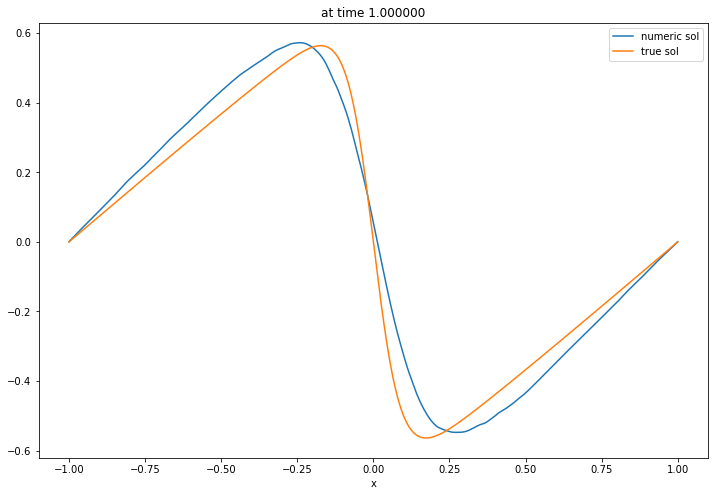

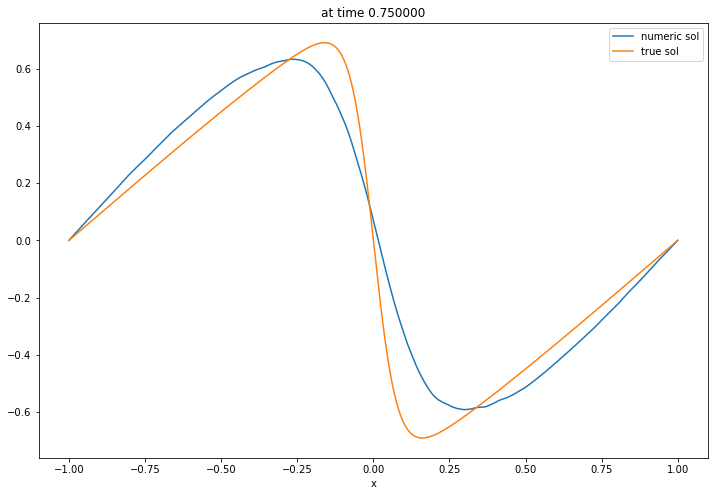

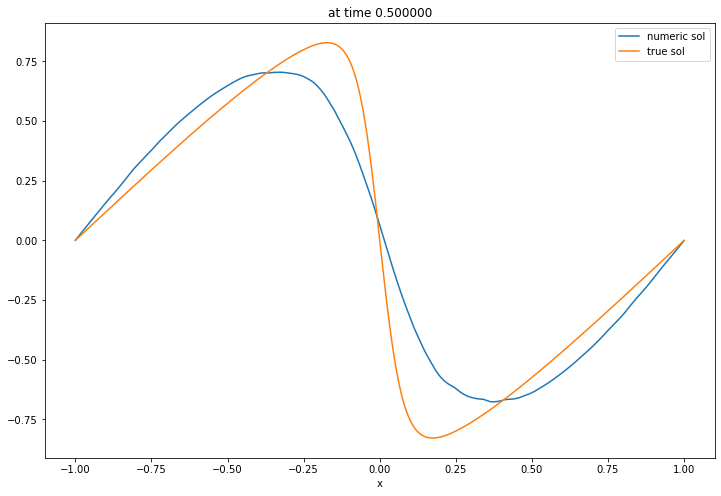

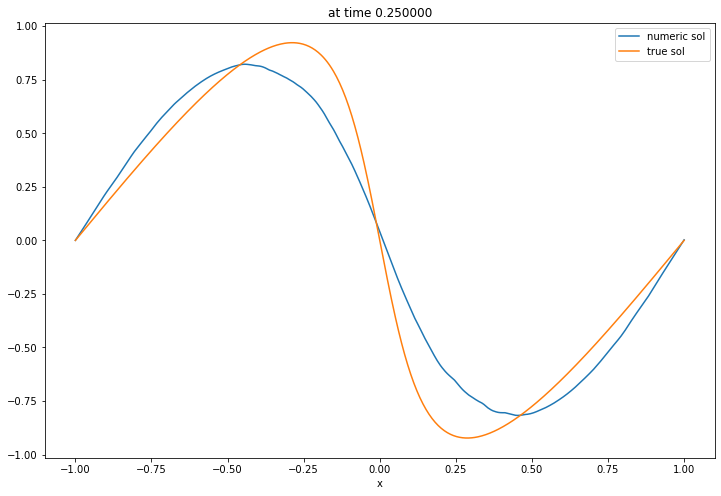

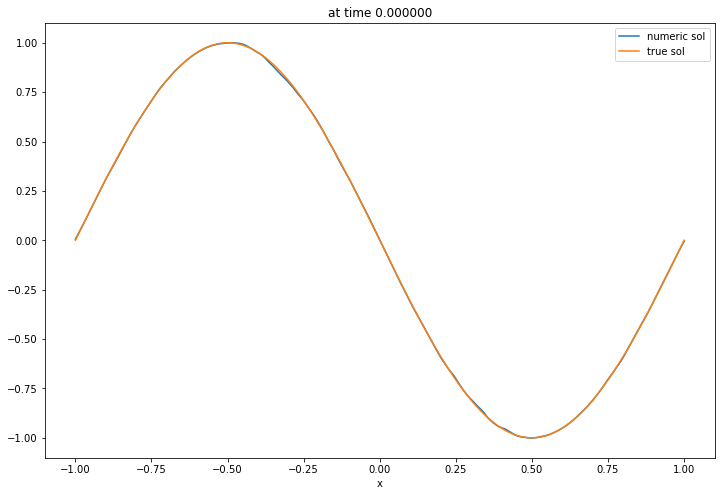

In [13]:
def sol_time_t(t, num_pts):
    xx=t
    yy = onp.linspace(-1, 1, num_pts)
    XX, YY = onp.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = onp.array(XX.flatten())
    YYv = onp.array(YY.flatten())
    XXv=onp.expand_dims(XXv, axis=1) 
    YYv=onp.expand_dims(YYv, axis=1) 

    X_test=jnp.concatenate((XXv,YYv), axis=1)
    
    rhs_f = vmap(f)(X_domain_tot[:,0], X_domain_tot[:,1])  
    bdy_g = vmap(u)(X_boundary_tot[:,0], X_boundary_tot[:,1])
    v0 = sol[:N_domain_tot]
    v2 = sol[N_domain_tot:2*N_domain_tot]
    v3 = sol[2*N_domain_tot:]
    vv = jnp.concatenate((nu*v3+rhs_f-alpha*v0*v2, v2, v3, v0, bdy_g), axis=0)
    
    L = assembly_Theta(X_domain_tot, X_boundary_tot, nugget, set_sigma)
    extended_u = extend_solution(X_test, L, vv)

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(yy, extended_u, label='numeric sol')
    ax.set_xlabel('x')
    
    
    u_truth=onp.vectorize(u_true)(XXv, YYv)
    ax.plot(yy, u_truth, label='true sol')
    ax.legend()
    plt.title('at time %f' %t)
    plt.show()

sol_time_t(1,200)  

sol_time_t(0.75,200)

sol_time_t(0.5,200)

sol_time_t(0.25,200)

sol_time_t(0, 200)